# Automated Segmentation of Bones for the Age Assessment in 3D MR Images using Convolutional Neural Networks

by [Paul-Louis Pröve](https://github.com/pietz)

## 1 Imports

In [1]:
from utils import *
%matplotlib inline

Using TensorFlow backend.


## 2 Preprocess Data

Load the precropped MRIs and corresponding segmentation masks. Resize X and Y dimensions to 224px, while keeping the original Z resolution. Load the masks 3 separate channels and apply N4 Bias Field correction to the MRIs. N4ITK needs 2-4 minutes for every 3D image. Time to make some coffee.

In [2]:
x_epi, y_epi = load_data('data/Epi_Study/VOI_LABEL/*.mhd', label=3, size=(224,224), norm=True)
x_jop, y_jop = load_data('data/Jopp_Study/VOI_LABEL/*.mhd', label=3, size=(224,224), norm=True)

100%|██████████| 40/40 [00:20<00:00,  1.90it/s]


There are 36 Epi and 40 Jopp images, giving us 76 samples for segmentation in total. Shuffle the data, but keep correct assignment between MRIs and masks.

In [3]:
x_epi, y_epi = shuffle(x_epi, y_epi)
x_jop, y_jop = shuffle(x_jop, y_jop)

Create the 3 data splits by slicing each portion, converting to 2D and merging both sources.

- Training Set - 56 samples - 74%
- Validation Set - 10 samples - 13%
- Test Set - 10 samples - 13%

In [4]:
x_tr = np.concatenate((to_2d(x_epi[:-10]), to_2d(x_jop[:-10])))
y_tr = np.concatenate((to_2d(y_epi[:-10]), to_2d(y_jop[:-10])))
x_va = np.concatenate((to_2d(x_epi[-10:-5]), to_2d(x_jop[-10:-5])))
y_va = np.concatenate((to_2d(y_epi[-10:-5]), to_2d(y_jop[-10:-5])))
x_te = np.concatenate((to_2d(x_epi[-5:]), to_2d(x_jop[-5:])))
y_te = np.concatenate((to_2d(y_epi[-5:]), to_2d(y_jop[-5:])))

In [5]:
print(x_tr.min(), x_tr.max())
print(x_va.min(), x_va.max())
print(x_te.min(), x_te.max())

-1.96111 5.9274
-1.45326 4.96854
-1.73199 4.5898


In [ ]:
np.savez('data/data_2.npz', x_tr=x_tr, y_tr=y_tr, x_va=x_va, y_va=y_va, x_te=x_te, y_te=y_te)

## 3 Load Data

In [2]:
x_tr = np.load('data/data.npz')['x_tr']
y_tr = np.load('data/data.npz')['y_tr']
x_va = np.load('data/data.npz')['x_va']
y_va = np.load('data/data.npz')['y_va']

Optional: Add noise to the training and validation data

In [3]:
#y_tr_noise = add_noise(y_tr, 7)
#y_va_noise = add_noise(y_va, 7)
#f1_np(y_tr, y_tr_noise)

Optional: Augment the images

In [4]:
x_tr, y_tr = augment(x_tr, y_tr, h_shift=[24,-24], h_flip=False, v_flip=False)

Sanity check on the samples

In [5]:
print_info(x_tr)
print_info(y_tr)

(5358, 224, 224, 1) - Min: -2.09244 - Mean: -0.0594157 - Max: 4.4225
(5358, 224, 224, 3) - Min: 0.0 - Mean: 0.0963067 - Max: 1.0


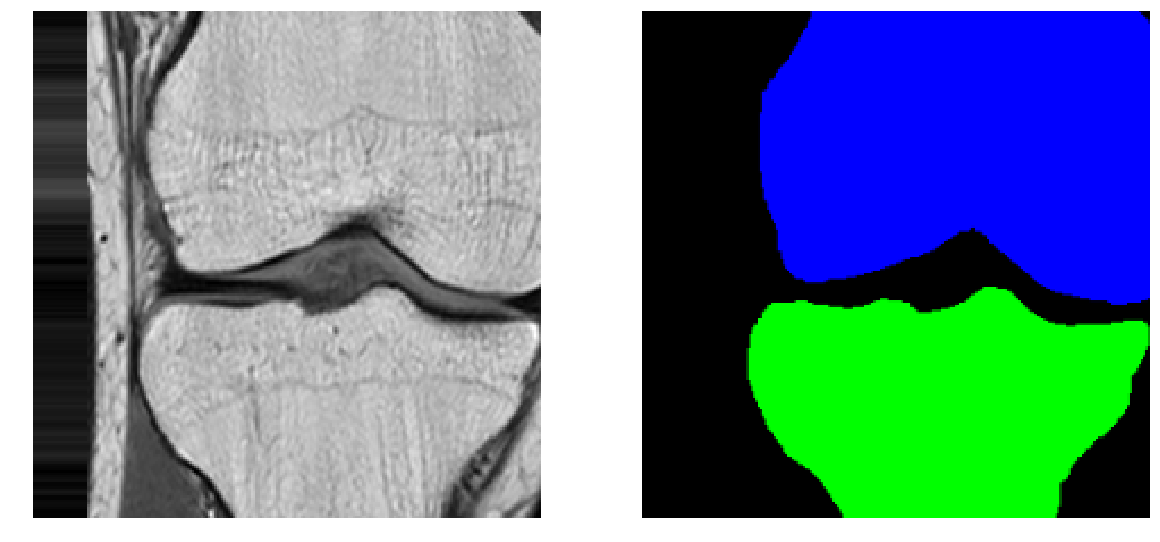

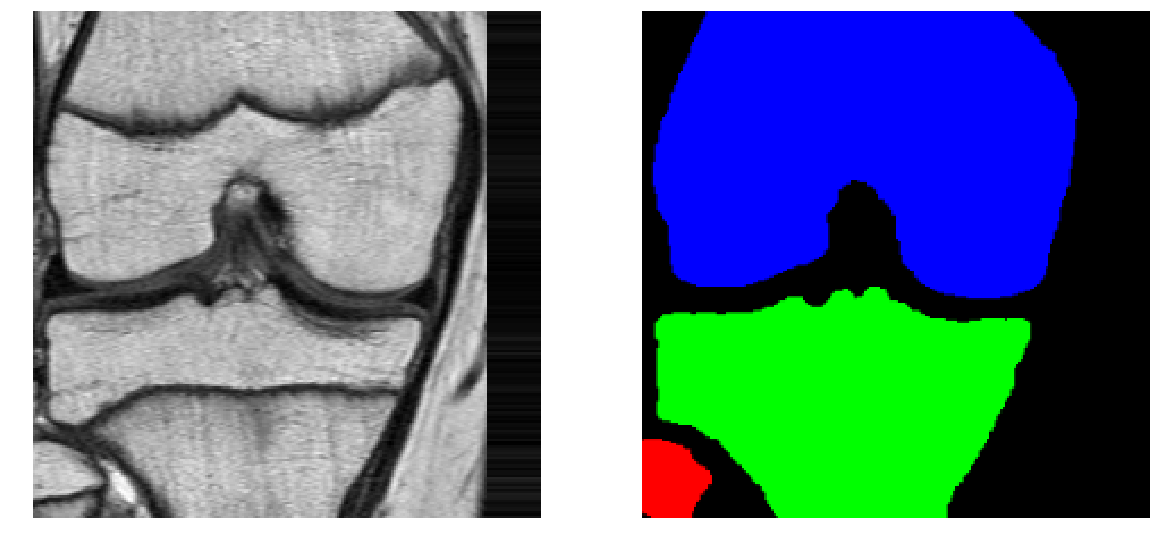

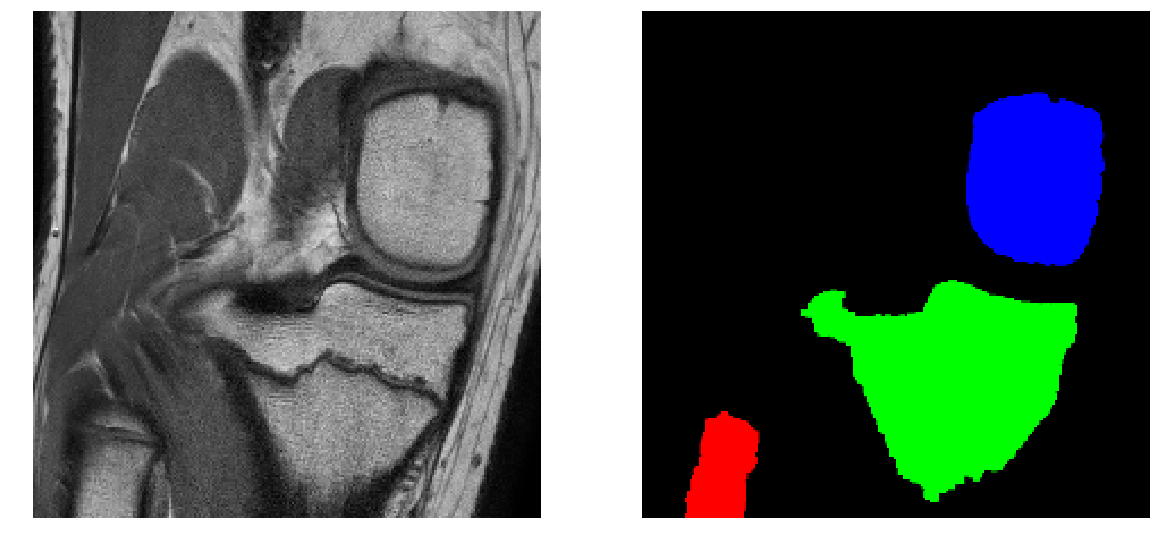

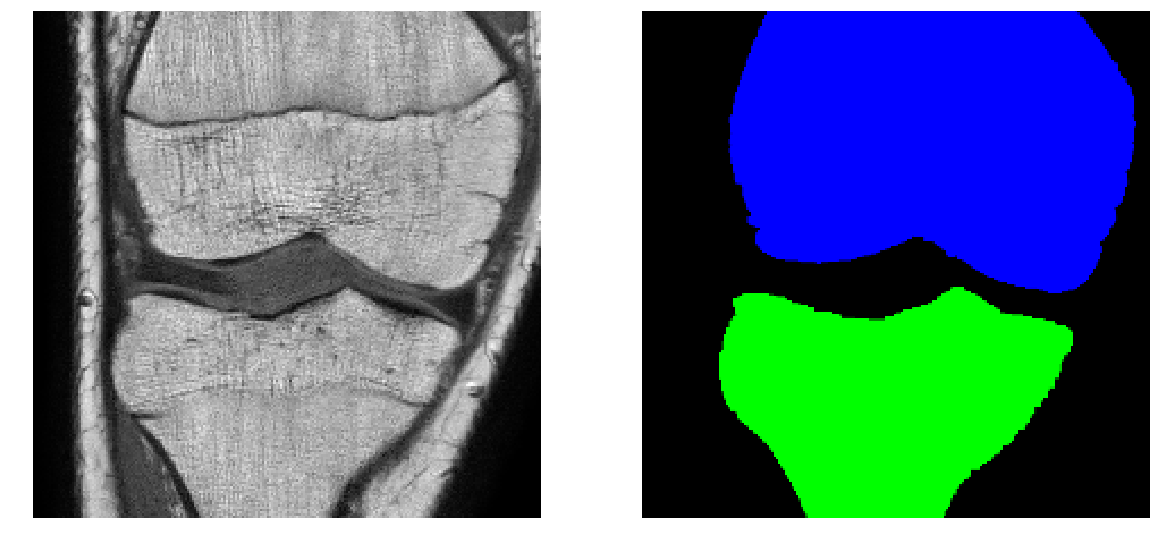

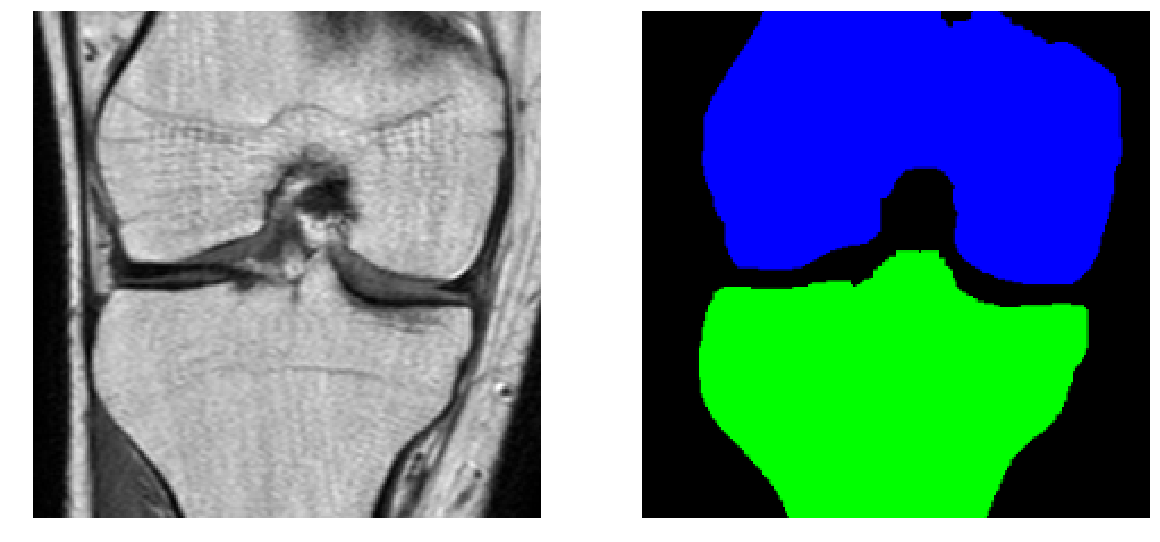

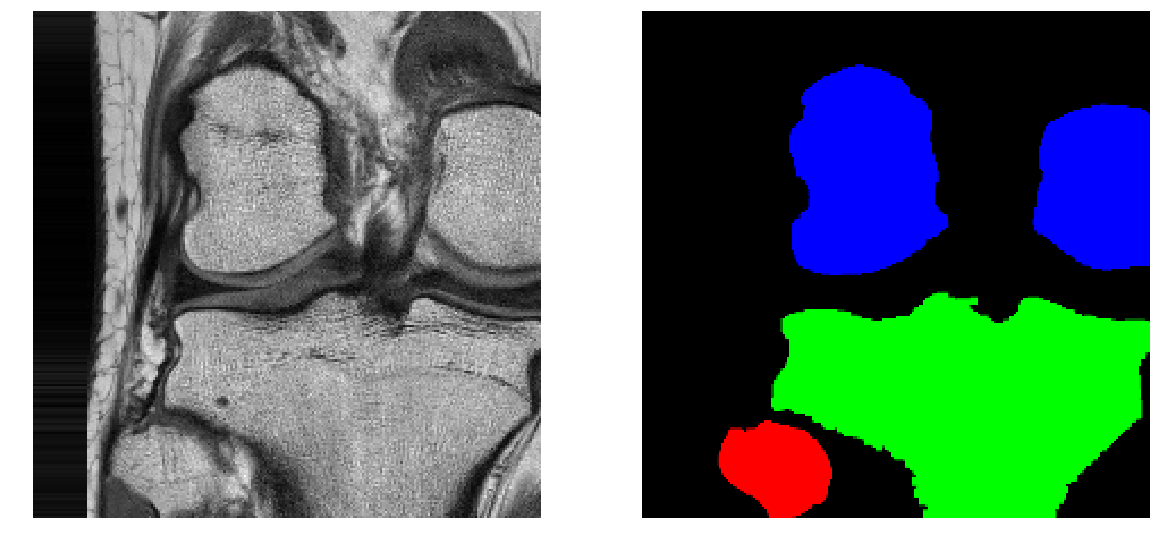

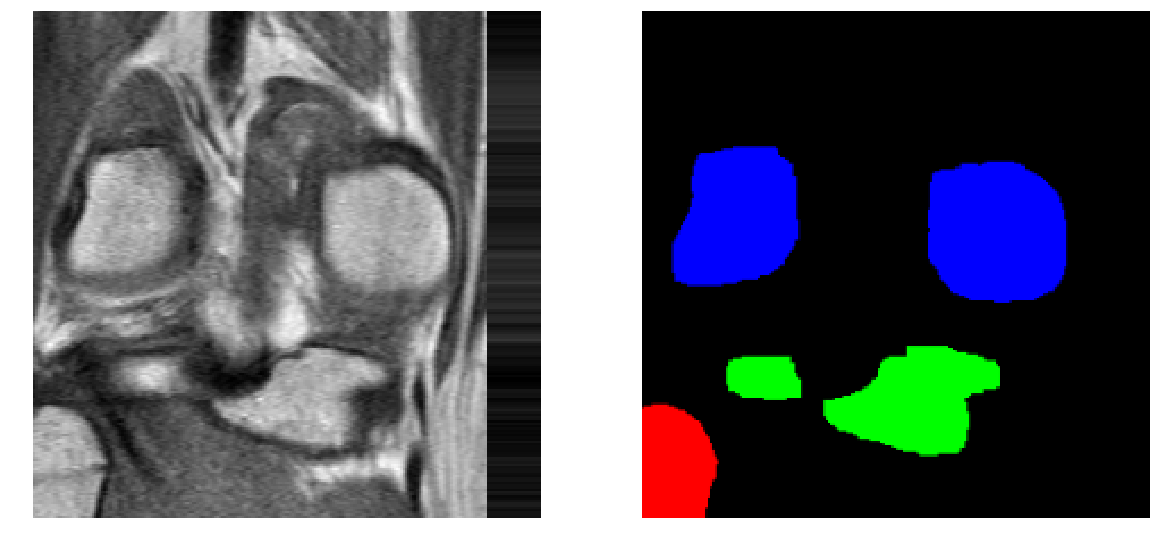

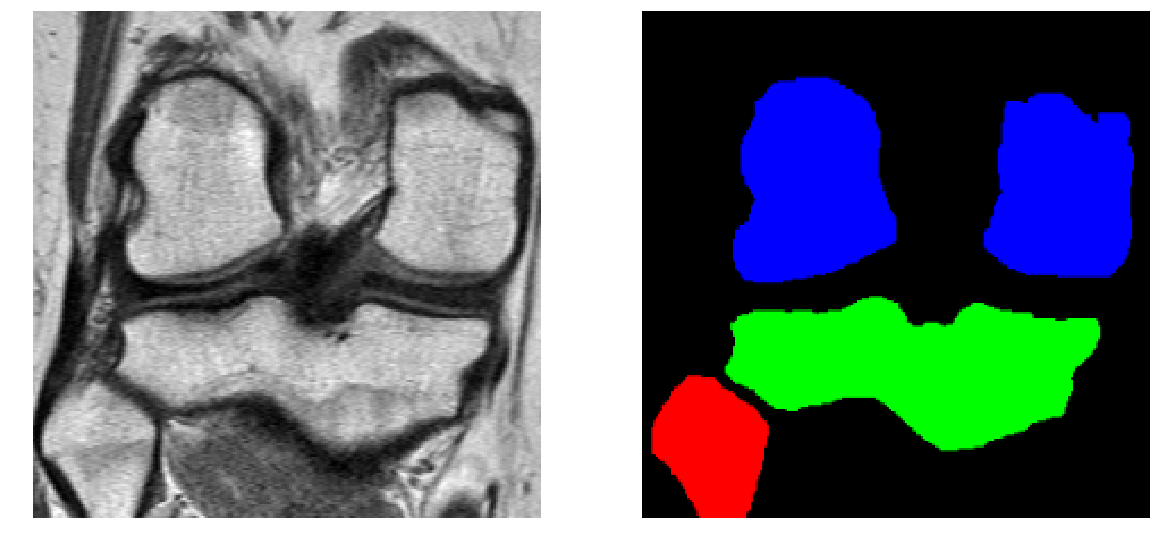

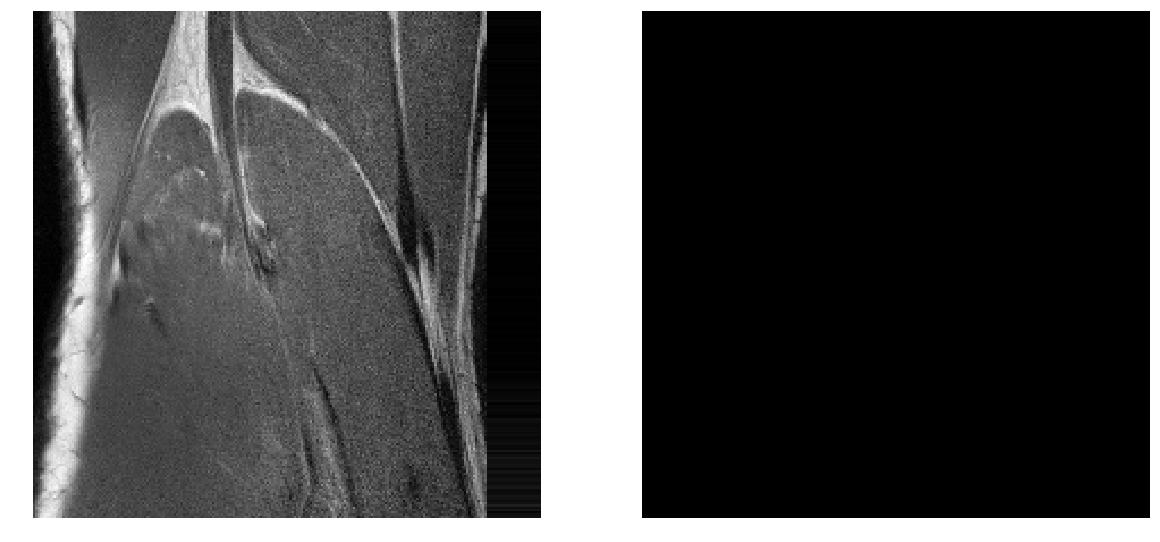

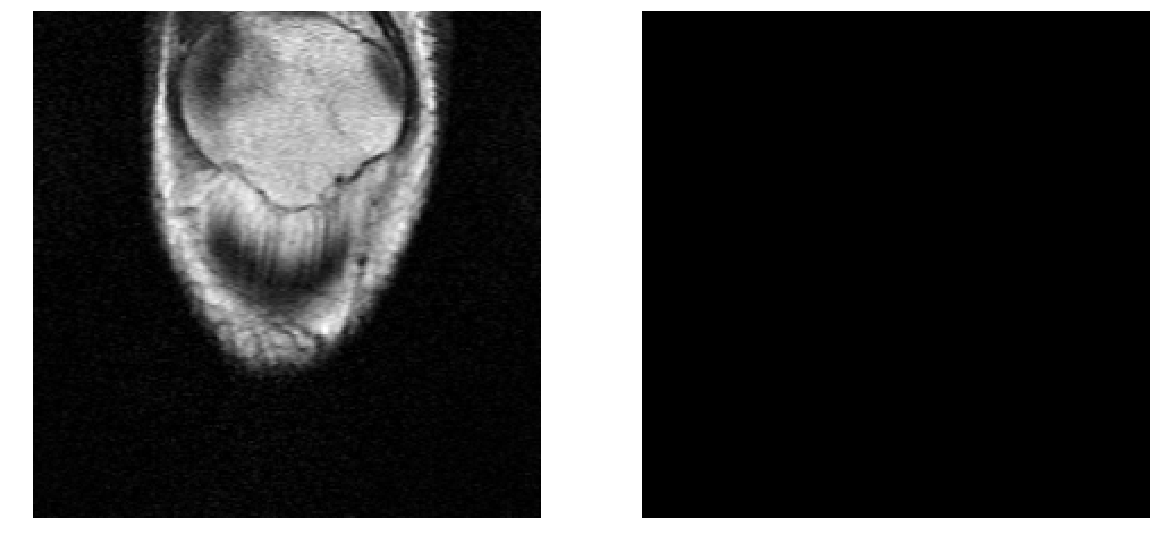

In [6]:
show_samples_2d([x_tr, y_tr], 10)

## 4 Training

#### Merged Model

The merged model combines all three bones in one channel and can therefore not differentiate between them.

In [ ]:
model = UNet(x_tr.shape[1:], 1, 32, 4, 1, 'elu', upconv=False)
model.compile(optimizer=Adam(lr=0.001), loss=f1_loss)
mc = ModelCheckpoint('weights/seg_merged_2.h5', save_best_only=True, save_weights_only=True)
es = EarlyStopping(patience=9)
model.fit(x_tr, y_tr.sum(axis=-1)[..., np.newaxis], 
          validation_data=(x_va, y_va.sum(axis=-1)[..., np.newaxis]), 
          epochs=50, batch_size=48, callbacks=[mc, es])

#### Separate Bones
Train the three bones separately.

In [ ]:
model = UNet((x_tr.shape[1:]), 1, 32, 4, 1, 'elu', upconv=False)
model.compile(optimizer=Adam(lr=0.001), loss=f1_loss)
mc = ModelCheckpoint('weights/seg_fibula_2.h5', save_best_only=True, save_weights_only=True)
es = EarlyStopping(patience=9)
model.fit(x_tr, y_tr[..., 0, np.newaxis], validation_data=(x_va, y_va[..., 0, np.newaxis]), 
          epochs=50, batch_size=48, callbacks=[mc, es])

In [ ]:
model = UNet((x_tr.shape[1:]), 1, 32, 4, 1, 'elu', upconv=False)
model.compile(optimizer=Adam(lr=0.001), loss=f1_loss)
mc = ModelCheckpoint('weights/seg2d_tibia_2.h5', save_best_only=True, save_weights_only=True)
es = EarlyStopping(patience=9)
model.fit(x_tr, y_tr[..., 1, np.newaxis], validation_data=(x_va, y_va[..., 1, np.newaxis]), 
          epochs=50, batch_size=48, callbacks=[mc, es])

In [ ]:
model = UNet((x_tr.shape[1:]), 1, 32, 4, 1, 'elu', upconv=False)
model.compile(optimizer=Adam(lr=0.001), loss=f1_loss)
mc = ModelCheckpoint('weights/seg_femur_2.h5', save_best_only=True, save_weights_only=True)
es = EarlyStopping(patience=9)
model.fit(x_tr, y_tr[..., 2, np.newaxis], validation_data=(x_va, y_va[..., 2, np.newaxis]), 
          epochs=50, batch_size=48, callbacks=[mc, es])

#### Transfer Model

For the transfer model activate all augmentations and then train for only 5 epochs

In [ ]:
model = UNet(x_tr.shape[1:], 1, 32, 4, 1, 'elu', upconv=False)
model.compile(optimizer=Adam(lr=0.001), loss=f1_loss)
mc = ModelCheckpoint('weights/seg_transfer_2.h5', save_best_only=True, save_weights_only=True)
es = EarlyStopping(patience=9)
model.fit(x_tr, y_tr, validation_data=(x_va, y_va), 
          epochs=5, batch_size=48, callbacks=[mc, es])

## 5 Validation

Execute this block if you want to test the merged model...

In [ ]:
model = UNet(x_va.shape[1:], 1, 32, 4, 1, 'elu', upconv=False)
model.compile(optimizer=Adam(lr=0.001), loss=f1_loss)

model.load_weights('weights/seg_merged.h5')
p_va = model.predict(x_va, batch_size=8, verbose=1)

for i in range(len(p_va)):
    if p_va[i].sum() < 1000:
        p_va[i] = 0

...or this block if you want to verify the combined separate channels.

In [7]:
model = UNet(x_va.shape[1:], 1, 32, 4, 1, 'elu', upconv=False)
model.compile(optimizer=Adam(lr=0.001), loss=f1_loss, metrics=[f1])

model.load_weights('weights/seg_fibula.h5')
p_fib = model.predict(x_va, batch_size=8, verbose=1)

model.load_weights('weights/seg_tibia.h5')
p_tib = model.predict(x_va, batch_size=8, verbose=1)

model.load_weights('weights/seg_femur.h5')
p_fem = model.predict(x_va, batch_size=8, verbose=1)

for i in range(len(p_tib)):
    if p_tib[i].sum() < 500:
        p_tib[i] = 0
    if p_fem[i].sum() < 500:
        p_fem[i] = 0
        
p_va = np.concatenate((p_fib, p_tib, p_fem), axis=-1)

325/325 [==============================] - 41s    


Make the segmentation prediction binary

In [8]:
threshold = 0.3
p_va[p_va >= threshold] = 1
p_va[p_va < threshold] = 0
y_va[y_va >= 0.5] = 1
y_va[y_va < 0.5] = 0

Calculate different metrics

In [9]:
print('DICE:      ' + str(f1_np(y_va, p_va)))
print('IoU:       ' + str(iou_np(y_va, p_va)))
print('Precision: ' + str(precision_np(y_va, p_va)))
print('Recall:    ' + str(recall_np(y_va, p_va)))
print('Error:     ' + str(error_np(y_va, p_va)))

DICE:      0.981027953039
IoU:       0.962762383775
Precision: 0.98148222917
Recall:    0.980574101198
Error:     0.00370926134877


## 6 Results

Load the test data

In [10]:
x_te = np.load('data/data.npz')['x_te']
y_te = np.load('data/data.npz')['y_te']

Predict the merged model

In [ ]:
model = UNet(x_te.shape[1:], 1, 32, 4, 1, 'elu', upconv=False)
model.compile(optimizer=Adam(lr=0.001), loss=f1_loss)

model.load_weights('weights/seg_merged.h5')
p_te = model.predict(x_te, batch_size=8, verbose=1)

for i in range(len(p_te)):
    if p_te[i].sum() < 1000:
        p_te[i] = 0

Predict the combined model

In [11]:
model = UNet(x_te.shape[1:], 1, 32, 4, 1, 'elu', upconv=False)
model.compile(optimizer=Adam(lr=0.001, decay=0.001), loss=f1_loss, metrics=[f1])

model.load_weights('weights/seg_fibula.h5')
p_fib = model.predict(x_te, batch_size=8, verbose=1)

model.load_weights('weights/seg_tibia.h5')
p_tib = model.predict(x_te, batch_size=8, verbose=1)

model.load_weights('weights/seg_femur.h5')
p_fem = model.predict(x_te, batch_size=8, verbose=1)

for i in range(len(p_tib)):
    if p_tib[i].sum() < 500:
        p_tib[i] = 0
    if p_fem[i].sum() < 500:
        p_fem[i] = 0
        
p_te = np.concatenate((p_fib, p_tib, p_fem), axis=-1)

325/325 [==============================] - 41s    


Apply the threshold

In [12]:
threshold = 0.3
p_te[p_te >= threshold] = 1
p_te[p_te < threshold] = 0
y_te[y_te >= 0.5] = 1
y_te[y_te < 0.5] = 0

Calculate metrics

In [13]:
print('DSC:       ' + str(f1_np(y_te, p_te)))
print('IoU:       ' + str(iou_np(y_te, p_te)))
print('Precision: ' + str(precision_np(y_te, p_te)))
print('Recall:    ' + str(recall_np(y_te, p_te)))
print('Error:     ' + str(error_np(y_te, p_te)))

DSC:       0.979112647867
IoU:       0.959080010333
Precision: 0.978621005141
Recall:    0.979604789289
Error:     0.00400197458791


Calculate difference between prediction and ground truth

In [14]:
if p_te.shape[-1] == y_te.shape[-1]:
    diff = abs(y_te-p_te)
else:
    diff = abs(y_te.sum(axis=-1)[..., np.newaxis]-p_te)

Look at a few results

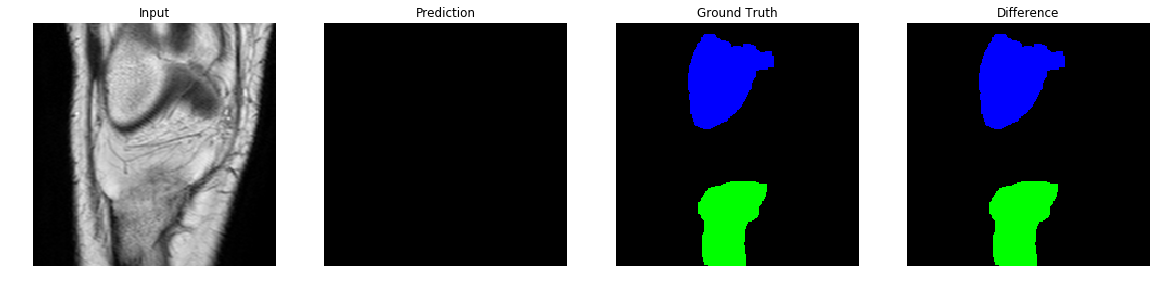

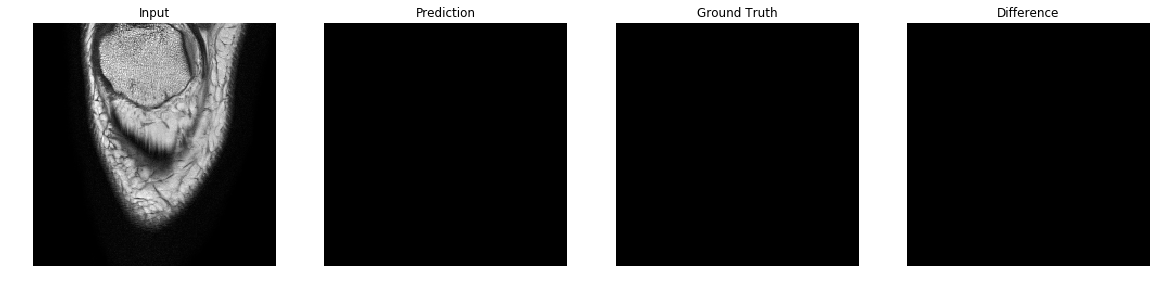

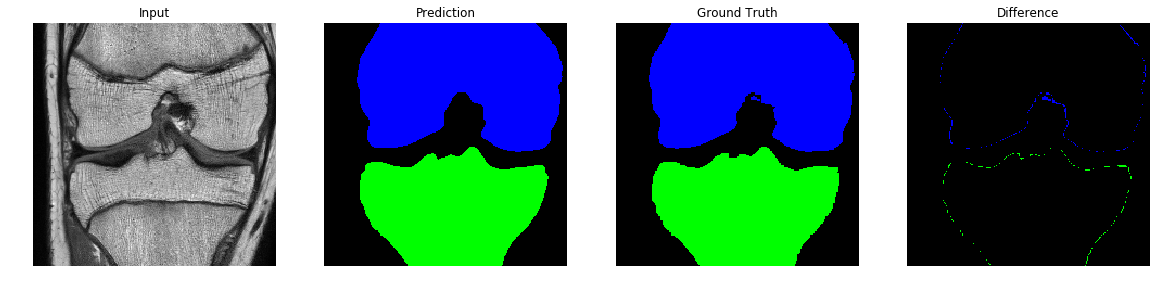

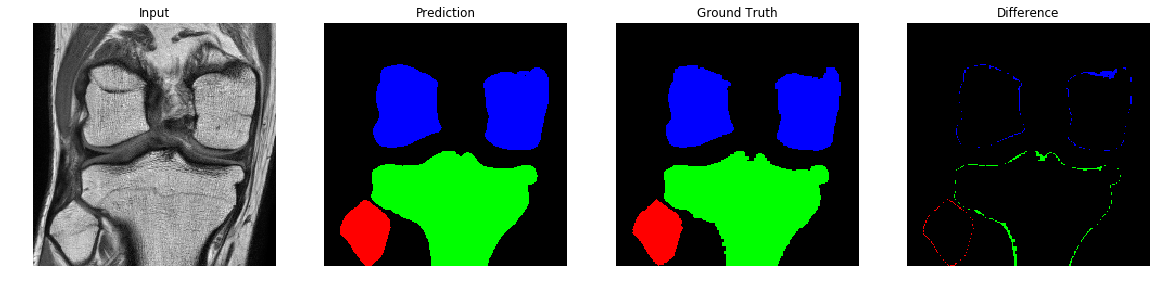

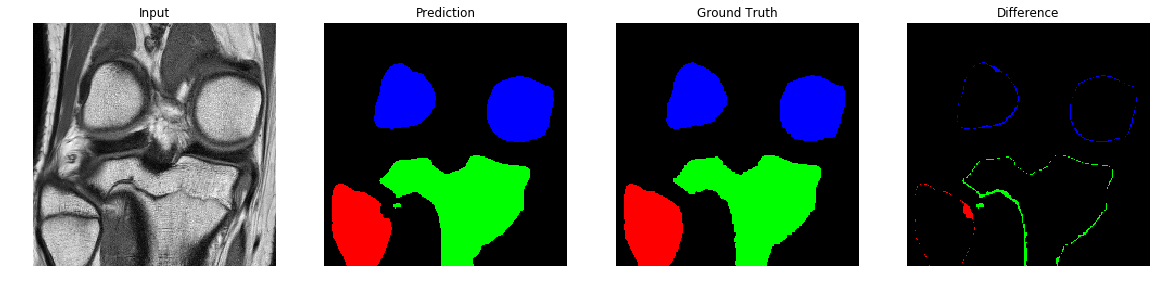

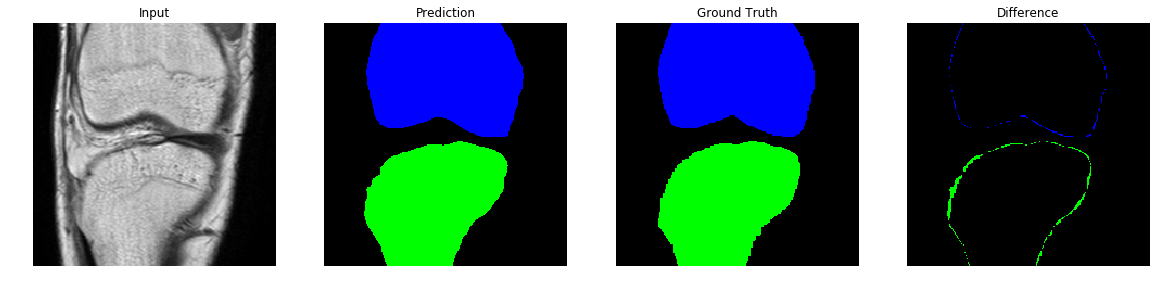

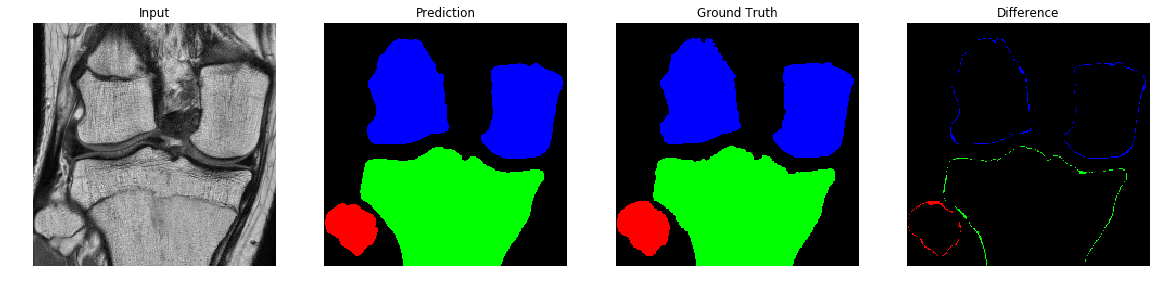

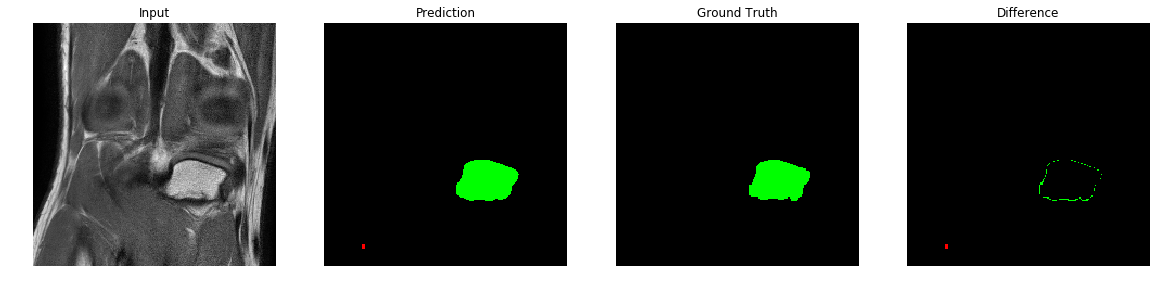

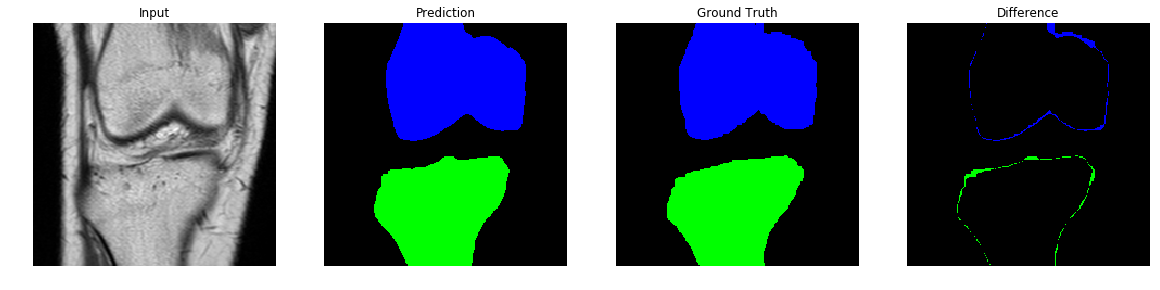

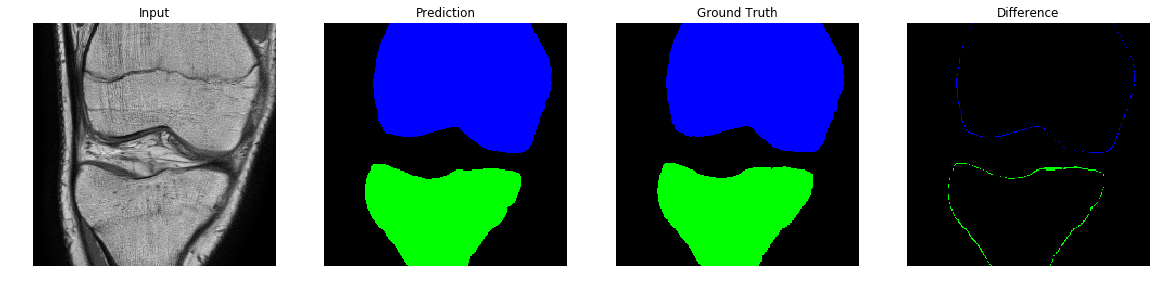

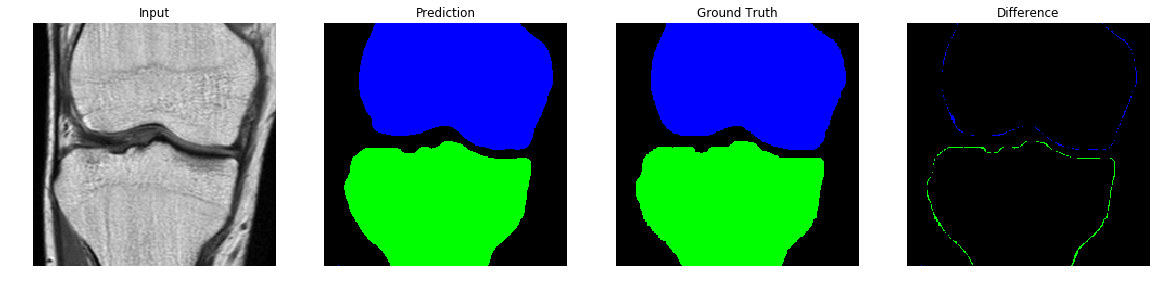

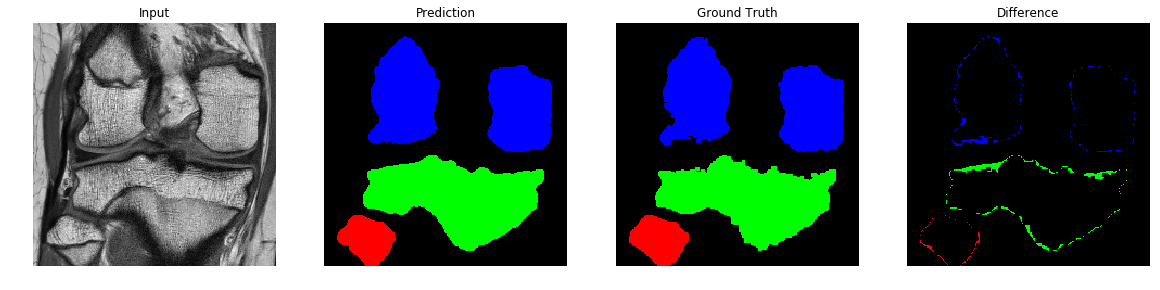

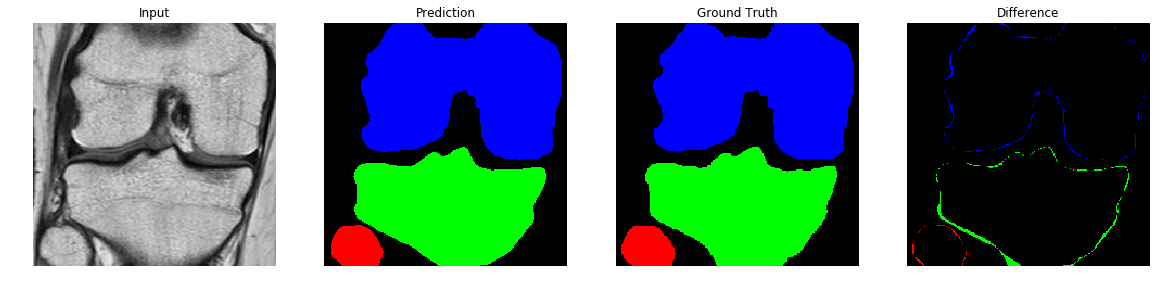

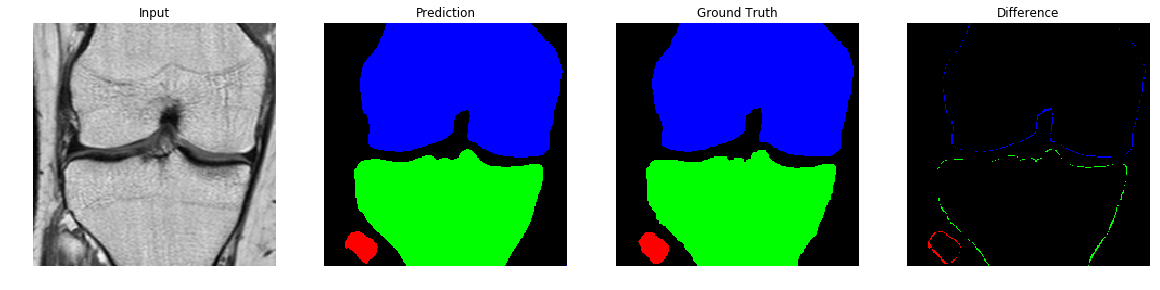

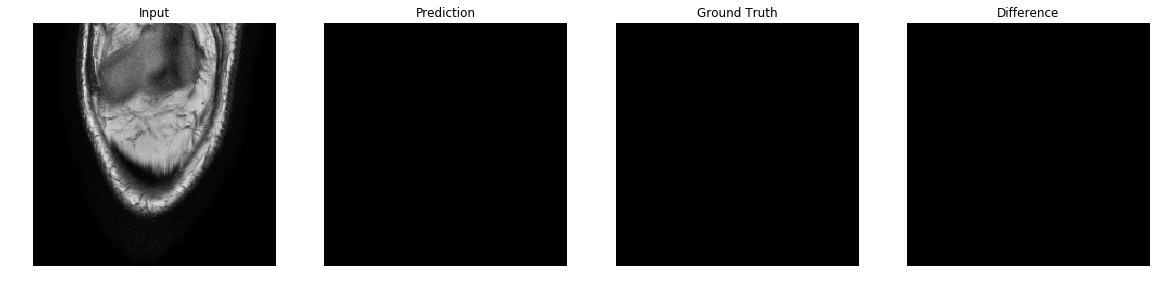

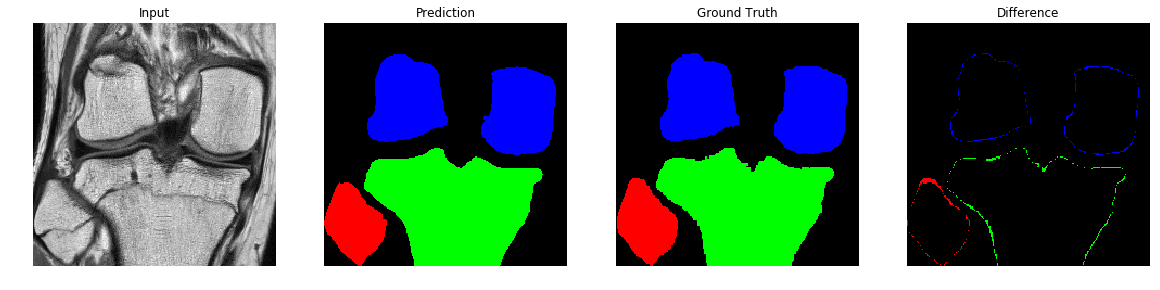

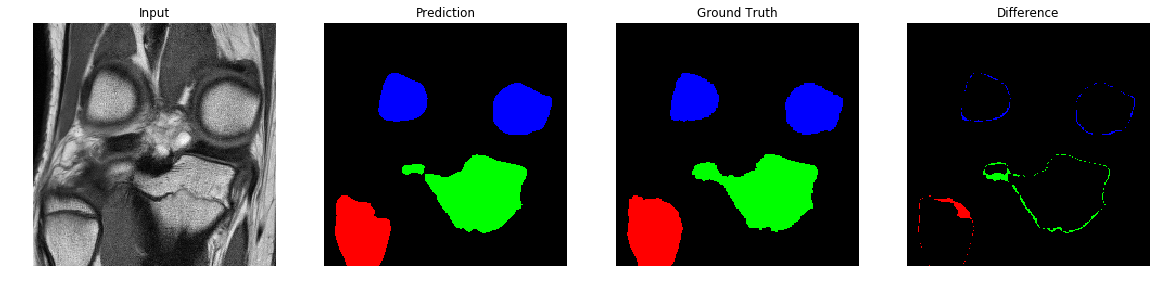

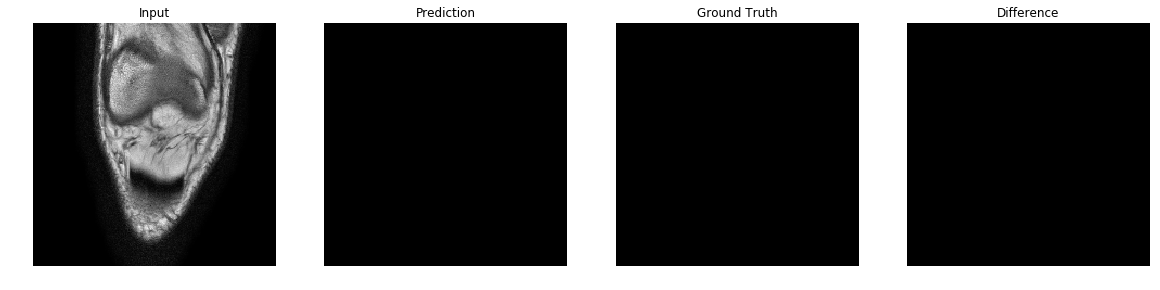

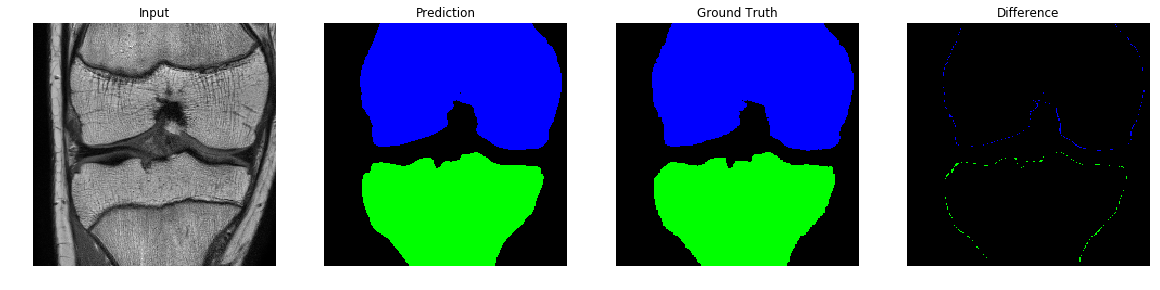

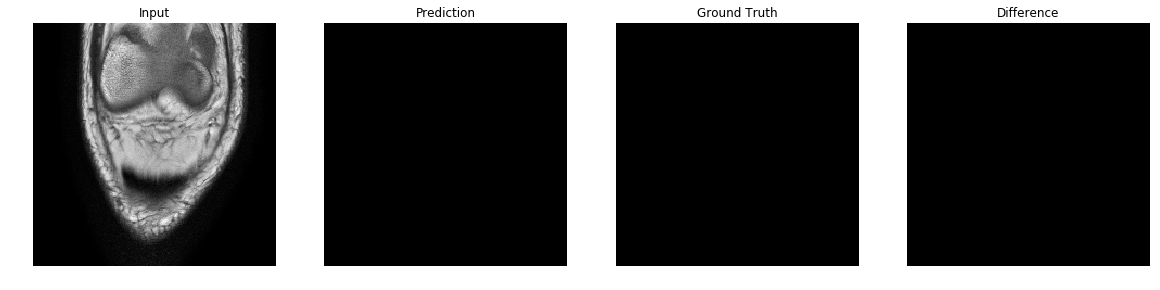

In [15]:
show_samples_2d([x_te, p_te, y_te, diff], 20, ['Input', 'Prediction', 'Ground Truth', 'Difference'])